# Compute the AMOC and MHT at 26N

This notebook shows how to compute the Atlantic Meridional Overturning Circulation (AMOC) and the Meridional Heat Transport at 26N. 
Here we demonstrate how to:
- use [xgcm](https://github.com/xgcm/xgcm) to compute masks and grab values at a particular latitude band
- use [xecco](https://github.com/timothyas/xecco) to select a specific basin
- compute volumetric transport and the overturning streamfunction
- compute meridional heat transport

Note that each of these tasks can be accomplished more succinctly with [xecco](https://github.com/timothyas/xecco) functions, but are shown explicitly to illustrate these tools. 

For this notebook, monthly data during 1992 are used to make a quick example. 

To do: 
- drop in tile_plot after it's fixed 
- remove output from Atl function...

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart

import ecco_v4_py as ecco
import xecco

## Load the diagnostic output 

Because we're computing transport, we want the files containing 'UVELMASS' and 'VVELMASS' for volumetric transport, and 'ADVx_TH', 'ADVy_TH' and 'DFxE_TH', 'DFyE_TH' for the advective and diffusive components of heat transport, respectively. 

In [3]:
grid_dir = '../../grids/llc90'
data_dir = '../../results/eccov4r3/ref_2015/diags/'

In [5]:
ds = xecco.load_mds(data_dir=data_dir,grid_dir=grid_dir)
ds.THETA

<xarray.DataArray 'THETA' (time: 12, k: 50, tile: 13, j: 90, i: 90)>
dask.array<shape=(12, 50, 13, 90, 90), dtype=float32, chunksize=(1, 1, 1, 90, 90)>
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * tile       (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter       (time) int64 dask.array<shape=(12,), chunksize=(1,)>
  * time       (time) datetime64[ns] 2014-12-31T12:00:00 ... 2015-12-31
    XC         (tile, j, i) >f8 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YC         (tile, j, i) >f8 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    CS         (tile, j, i) >f8 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    SN         (tile, j, i) >f8 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    Z          (k) >f8 dask.array<shape=(50,), chunksize=

## Grab the desired latitude band

Here we want to grab the transport values which along the band closest represented in the model to 26$^\circ$N. 
In a latitude longitude grid this could simply be done by, e.g. `U.sel(lat=26)`. 
However, the LLC grid is slightly more complicated. 
Luckily, the functionality enabled by the [xgcm Grid object](https://xgcm.readthedocs.io/en/latest/api.html#grid) make this relatively easy. 

Here we compute a mask which grabs the desired values.
Note that this mirrors the gcmfaces function [gcmfaces_calc/gcmfaces_lines_zonal.m](https://github.com/gaelforget/gcmfaces/blob/readthedocs/gcmfaces_calc/gcmfaces_lines_zonal.m).

Note that this can be done easily with the xecco modules [vector_calc](https://github.com/timothyas/xecco/blob/master/xecco/vector_calc.py) and [scalar_calc](https://github.com/timothyas/xecco/blob/master/xecco/scalar_calc.py) as follows:

```
grid = xecco.get_llc_grid(ds)
rapid_maskW, rapid_maskS = xecco.vector_calc.get_latitude_masks(lat_val=26,yc=ds.YC,grid=grid)
rapid_maskC = xecco.scalar_calc.get_latitude_masks(lat_val=26,yc=ds.YC,grid=grid)
```

In [5]:
# Get array of 1's at and north of latitude
lat = 26
ones = xr.ones_like(ds.YC)
dome_maskC = ones.where(ds.YC>=lat,0)

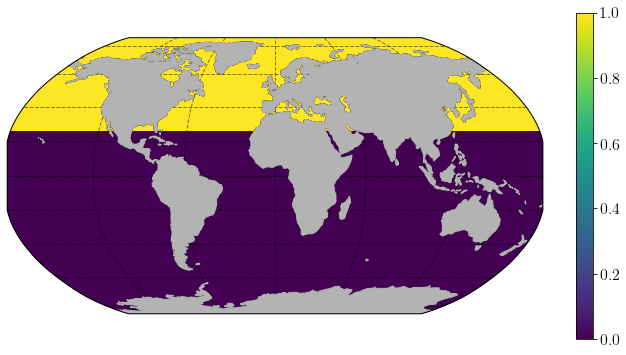

In [20]:
plt.figure(figsize=(12,6))
fig,ax,p,cb=ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,dome_maskC,
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

Again, if this were a lat/lon grid we could simply take a finite difference in the meridional direction. 
The only grid cells with 1's remaining would be at the southern edge of grid cells at approximately 26$^\circ$N.

However, recall that the LLC grid has a different picture.

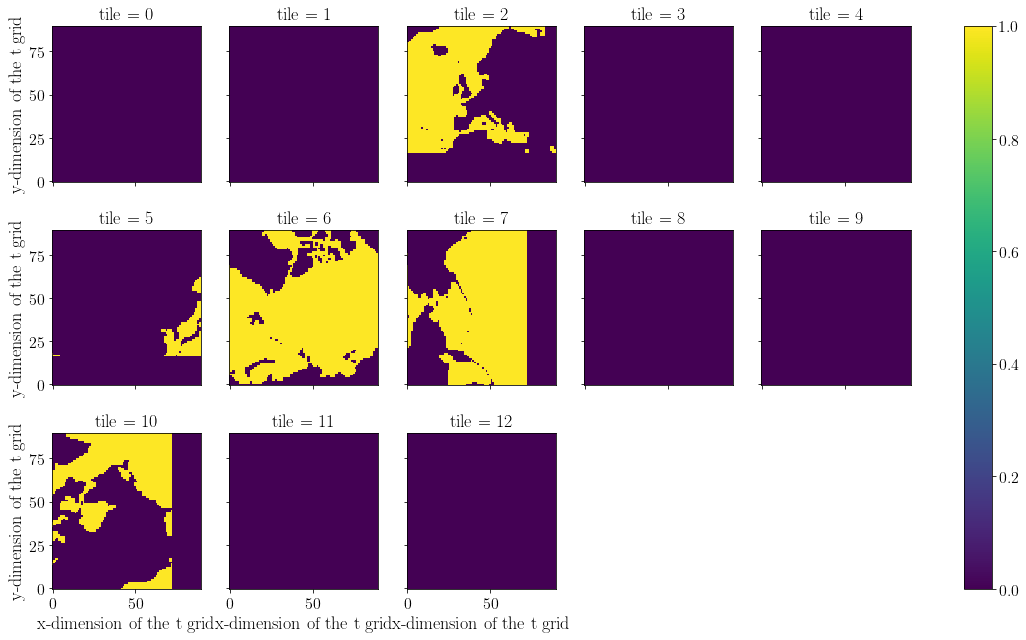

In [7]:
dome_maskC.attrs['units']='degNorth' # For some reason xarray plotting has trouble with '_' in titles for latex
(dome_maskC * ds['maskC'].isel(k=0)).plot(col='tile',col_wrap=5)

Recall that for tiles 7-12, the y-dimension actually runs East-West. 
Therefore, we want to compute a finite difference in the x-dimension on these tiles to get the latitude band at 26$^\circ$N. 
For tiles 1-5, we clearly want to difference in the y-dimension. 
Things get more complicated on tile 6.

In [8]:
grid = xecco.get_llc_grid(ds)

In [11]:
lat_maskW = grid.diff(dome_maskC,'X',boundary='fill')
lat_maskS = grid.diff(dome_maskC,'Y',boundary='fill')

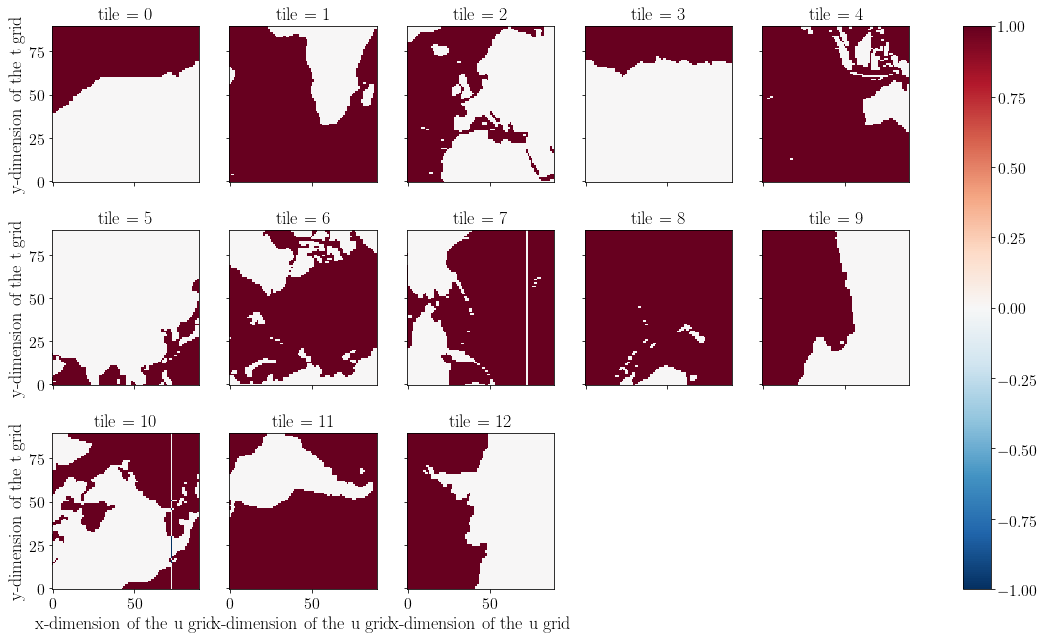

In [12]:
(lat_maskW + ds.maskW.isel(k=0)).plot(col='tile',col_wrap=5)

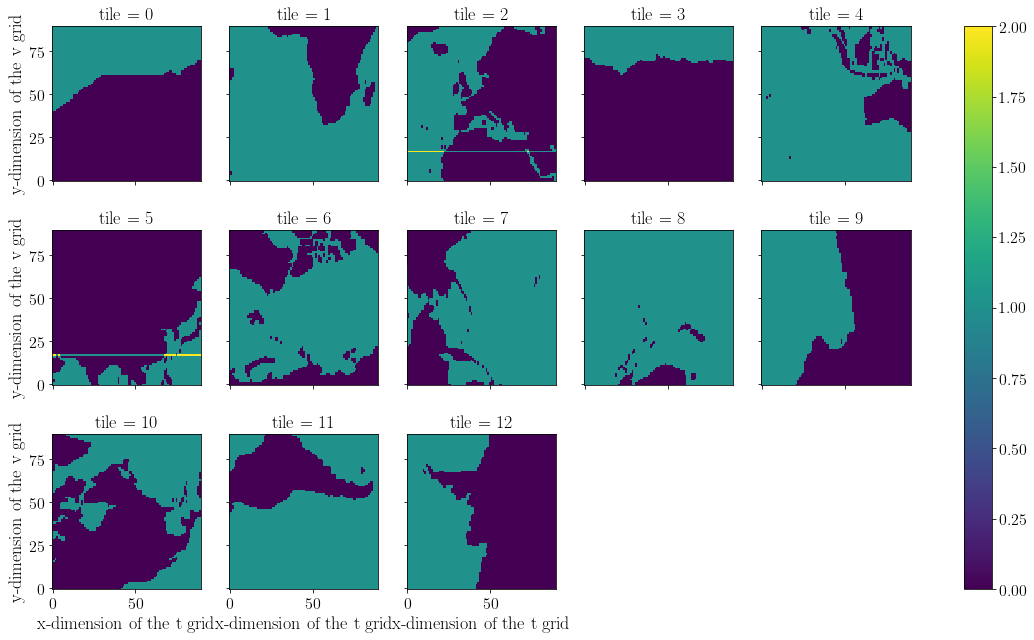

In [13]:
(lat_maskS + ds.maskS.isel(k=0)).plot(col='tile',col_wrap=5)

## Select the Atlantic ocean basin

Now that we have 26$^\circ$N we just need to select the Atlantic. 
This can be done with the `xecco.utils` module, specifically `xecco.utils.get_basin_mask`.
Note that this function requires a mask as an input, and then returns the values within a particular ocean basin.
Therefore, provide the function with `ds['maskC']` for a mask at tracer points, etc.

Note: this mirrors the gcmfaces functionality [ecco_v4/v4_basin.m](https://github.com/gaelforget/gcmfaces/blob/readthedocs/ecco_v4/v4_basin.m). 

Here we just want the Atlantic, but lets look at what options we have ...

In [14]:
print(xecco.get_available_basin_names())

['pac', 'atl', 'ind', 'arct', 'bering', 'southChina', 'mexico', 'okhotsk', 'hudson', 'med', 'java', 'north', 'japan', 'timor', 'eastChina', 'red', 'gulf', 'baffin', 'gin', 'barents']


Notice that, for instance, 'mexico' exists separately from the Atlantic ('atl'). 
This is to provide as fine granularity as possible (and sensible). 
To grab the broader Atlantic ocean basin, i.e. the one people usually refer to, use the option 'atlExt'. 
Similar options exist for the Pacific and Indian ocean basins.

In [15]:
atl_maskW = xecco.get_basin_mask(basin_name='atlExt',mask=ds['maskW'].isel(k=0))
atl_maskS = xecco.get_basin_mask(basin_name='atlExt',mask=ds['maskS'].isel(k=0))

dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)


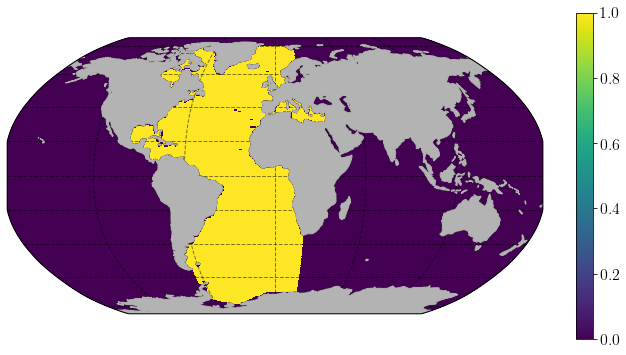

In [21]:
plt.figure(figsize=(12,6))
fig,ax,p,cb=ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,atl_maskW,
                              projection_type='robin',cmap='viridis',user_lon_0=0,show_colorbar=True)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

## At last, compute the AMOC

This can be done with the [calc_stf](https://github.com/timothyas/xecco/blob/master/xecco/calc_stf.py) module:  
```
psi_moc = xecco.calc_meridional_stf(ds,lat_vals=26,basin_name='atlExt')
amoc = psi_moc.max(dim='k')
```

In [22]:
ds['UVELMASS'].load();
ds['VVELMASS'].load();

In [23]:
# Compute volume transport across latitude band in the Atlantic
trsp_x = ds['UVELMASS'] * ds['drF'] * ds['dyG'] * lat_maskW * atl_maskW
trsp_y = ds['VVELMASS'] * ds['drF'] * ds['dxG'] * lat_maskS * atl_maskS

# Sum horizontally 
trsp_x = trsp_x.sum(dim=['i_g','j','tile'])
trsp_y = trsp_y.sum(dim=['i','j_g','tile'])

# Add together to get transport at depth level 
# and convert to Sv
trsp_at_depth = (trsp_x + trsp_y)*10**-6

# Compute the overturning streamfunction
# Flip depth dimension, take cumulative sum, flip back
psi_moc = trsp_at_depth.isel(k=slice(None,None,-1))
psi_moc = psi_moc.cumsum(dim='k')
psi_moc = -1 * psi_moc.isel(k=slice(None,None,-1))

# Compute maximum over depth
amoc = psi_moc.max(dim='k')

[16.86428383 19.68550197 15.51398918 12.76259449 15.45827861 13.10283699
 15.418995   15.41159828 13.2120109  14.39056459 17.67257714 17.51713332]


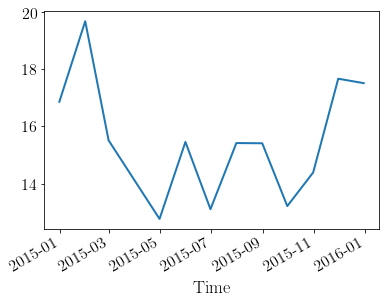

In [24]:
amoc.plot()
print(amoc.values)

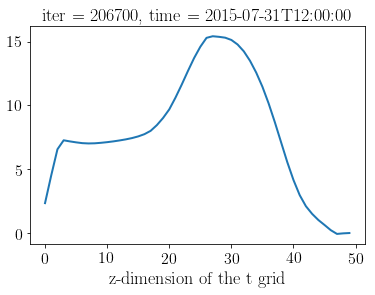

In [25]:
psi_moc.isel(time=6).plot()

## In a similar fashion, compute the meridional heat transport at this latitude

We can do this for volume, heat, or salt with the xecco module [calc_meridional_trsp](https://github.com/timothyas/xecco/blob/master/xecco/calc_meridional_trsp.py) 
```
mvt = xecco.calc_meridional_vol_trsp(ds,lat_vals=26,basin_name='atlExt')
mht = xecco.calc_meridional_heat_trsp(ds,lat_vals=26,basin_name='atlExt')
mst = xecco.calc_meridional_salt_trsp(ds,lat_vals=26,basin_name='atlExt')
```

In [26]:
ds['ADVx_TH'].load();
ds['DFxE_TH'].load();
ds['ADVy_TH'].load();
ds['DFyE_TH'].load();

In [27]:
trsp_x = (ds['ADVx_TH'] + ds['DFxE_TH']) * lat_maskW * atl_maskW
trsp_y = (ds['ADVy_TH'] + ds['DFyE_TH']) * lat_maskS * atl_maskS

# Sum horizontally 
trsp_x = trsp_x.sum(dim=['i_g','j','tile'])
trsp_y = trsp_y.sum(dim=['i','j_g','tile'])

# Add together to get transport at depth level 
trsp_at_depth = trsp_x + trsp_y

# Sum over full depth and convert to PW
mht = (trsp_at_depth *10**-15 * 1000 * 4000).sum('k')

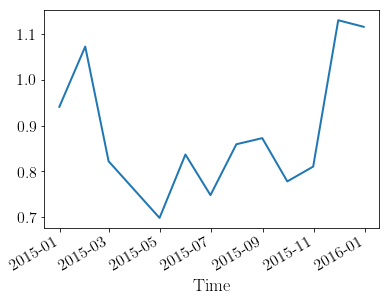

In [28]:
mht.plot()

## Note that we can also do this for many latitudes easily

In [29]:
lats = np.arange(-35,35)
mht_atl = xecco.calc_meridional_heat_trsp(ds,lat_vals=lats,grid=grid,basin_name='atlExt')

dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)
dims, num_dims, llc  (1170, 90) 2 90
2 dimensions
f3 shape  (90, 90)
f5 shape  (90, 270)
2D, data_compact shape  (1170, 90)


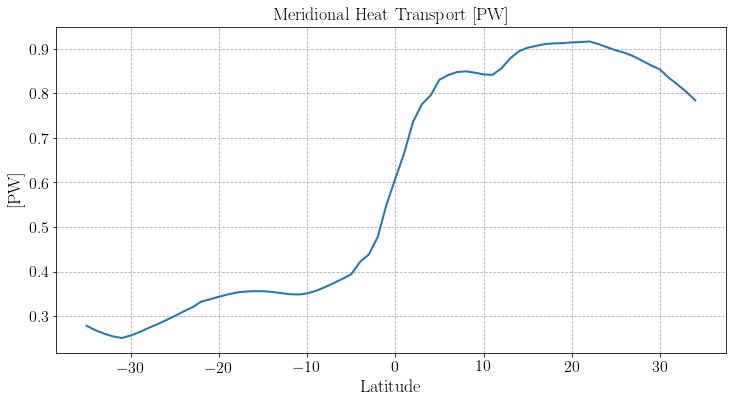

In [30]:
plt.figure(figsize=(12,6))
plt.plot(mht_atl['lat'], mht_atl.mean('time'))
plt.grid(linestyle='--')
plt.title('Meridional Heat Transport [%s]' % mht_atl.attrs['units'])
plt.ylabel('[%s]' % mht_atl.attrs['units'])
plt.xlabel('Latitude')
plt.show()